# Playground

## Load

In [1]:
from __future__ import annotations
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import theano.tensor as tt
import arviz as az

In [2]:
from m5 import __data__
from m5.data.ready import load_ds, path_ds
# from m5.data.prep import *
# from m5.data.raw import calendar, sell_prices, sales_train_eval, sales_train_valid, sample_submission

In [3]:
ds_all = load_ds()
# ds_all = load_ds(recalc=True)
ds = ds_all.where(ds_all['historic'], drop=True)
vars_int = ['sales', 'wday', 'month', 'year', 'event', 'snap']
for v in vars_int:
    ds[v] = ds[v].astype(int)
ds

<xarray.Dataset>
Dimensions:     (date: 1941, event_name: 30, item_id: 3049, store_id: 10)
Coordinates:
  * item_id     (item_id) object 'FOODS_1_001' ... 'HOUSEHOLD_2_516'
    cat_id      (item_id) object 'FOODS' 'FOODS' ... 'HOUSEHOLD' 'HOUSEHOLD'
    dept_id     (item_id) object 'FOODS_1' 'FOODS_1' ... 'HOUSEHOLD_2'
  * store_id    (store_id) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_1' 'WI_2' 'WI_3'
    state_id    (store_id) object 'CA' 'CA' 'CA' 'CA' ... 'TX' 'WI' 'WI' 'WI'
  * date        (date) datetime64[ns] 2011-01-29 2011-01-30 ... 2016-05-22
  * event_name  (event_name) object 'SuperBowl' 'ValentinesDay' ... 'Easter'
    event_type  (event_name) object 'Sporting' 'Cultural' ... 'Cultural'
    historic    (date) bool True True True True True ... True True True True
    future      (date) bool False False False False ... False False False False
Data variables:
    sales       (item_id, store_id, date) int64 3 0 0 1 4 2 0 ... 0 0 0 0 0 0 0
    price       (item_id, store_id, date) float64 2.0 2.0 2.0 ... 5.94 5.94 5.94
    wday        (date) int64 1 2 3 4 5 6 7 1 2 3 4 5 ... 5 6 7 1 2 3 4 5 6 7 1 2
    month       (date) int64 1 1 1 2 2 2 2 2 2 2 2 2 ... 5 5 5 5 5 5 5 5 5 5 5 5
    year        (date) int64 2011 2011 2011 2011 2011 ... 2016 2016 2016 2016
    event       (date, event_name) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    snap        (date, store_id) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

## Model - Unit Sales

### Prepare data

In [4]:
x = (
    ds
    #.sel({"store_id": ["CA_1"]})
    .isel({"item_id": slice(0, 100)})
    .isel({"date": slice(1500, None)})
    .transpose("date", "item_id", "store_id", "event_name")
)
x

<xarray.Dataset>
Dimensions:     (date: 441, event_name: 30, item_id: 100, store_id: 10)
Coordinates:
  * item_id     (item_id) object 'FOODS_1_001' 'FOODS_1_002' ... 'FOODS_1_102'
    cat_id      (item_id) object 'FOODS' 'FOODS' 'FOODS' ... 'FOODS' 'FOODS'
    dept_id     (item_id) object 'FOODS_1' 'FOODS_1' ... 'FOODS_1' 'FOODS_1'
  * store_id    (store_id) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_1' 'WI_2' 'WI_3'
    state_id    (store_id) object 'CA' 'CA' 'CA' 'CA' ... 'TX' 'WI' 'WI' 'WI'
  * date        (date) datetime64[ns] 2015-03-09 2015-03-10 ... 2016-05-22
  * event_name  (event_name) object 'SuperBowl' 'ValentinesDay' ... 'Easter'
    event_type  (event_name) object 'Sporting' 'Cultural' ... 'Cultural'
    historic    (date) bool True True True True True ... True True True True
    future      (date) bool False False False False ... False False False False
Data variables:
    sales       (date, item_id, store_id) int64 0 1 0 1 1 0 0 ... 0 0 1 1 3 0 2
    price       (date, item_id, store_id) float64 2.24 2.24 2.24 ... 1.78 1.78
    wday        (date) int64 3 4 5 6 7 1 2 3 4 5 6 7 ... 5 6 7 1 2 3 4 5 6 7 1 2
    month       (date) int64 3 3 3 3 3 3 3 3 3 3 3 3 ... 5 5 5 5 5 5 5 5 5 5 5 5
    year        (date) int64 2015 2015 2015 2015 2015 ... 2016 2016 2016 2016
    event       (date, event_name) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    snap        (date, store_id) int64 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0

In [5]:
d = x.copy()
d["log_price"] = np.log(d["price"]).fillna(0)
d.coords["day_of_week"] = np.arange(7, dtype=int)
d.coords["month_of_year"] = np.arange(12, dtype=int)

ref_date_ns = pd.Timestamp("2010-01-01").to_datetime64().astype(float)
d["date_f"] = (d["date"].astype(float) - ref_date_ns) / 1e15

_sls = d['sales'].sum(dim='item_id')
_sls = _sls.where(_sls > 0)
# d["store_sales"] = _sls.fillna(_sls.mean(dim='date'))

In [6]:
d

<xarray.Dataset>
Dimensions:        (date: 441, day_of_week: 7, event_name: 30, item_id: 100, month_of_year: 12, store_id: 10)
Coordinates:
  * item_id        (item_id) object 'FOODS_1_001' ... 'FOODS_1_102'
    cat_id         (item_id) object 'FOODS' 'FOODS' 'FOODS' ... 'FOODS' 'FOODS'
    dept_id        (item_id) object 'FOODS_1' 'FOODS_1' ... 'FOODS_1' 'FOODS_1'
  * store_id       (store_id) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_2' 'WI_3'
    state_id       (store_id) object 'CA' 'CA' 'CA' 'CA' ... 'TX' 'WI' 'WI' 'WI'
  * date           (date) datetime64[ns] 2015-03-09 2015-03-10 ... 2016-05-22
  * event_name     (event_name) object 'SuperBowl' 'ValentinesDay' ... 'Easter'
    event_type     (event_name) object 'Sporting' 'Cultural' ... 'Cultural'
    historic       (date) bool True True True True True ... True True True True
    future         (date) bool False False False False ... False False False
  * day_of_week    (day_of_week) int64 0 1 2 3 4 5 6
  * month_of_year  (month_of_year) int64 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    sales          (date, item_id, store_id) int64 0 1 0 1 1 0 0 ... 0 1 1 3 0 2
    price          (date, item_id, store_id) float64 2.24 2.24 ... 1.78 1.78
    wday           (date) int64 3 4 5 6 7 1 2 3 4 5 6 ... 6 7 1 2 3 4 5 6 7 1 2
    month          (date) int64 3 3 3 3 3 3 3 3 3 3 3 ... 5 5 5 5 5 5 5 5 5 5 5
    year           (date) int64 2015 2015 2015 2015 2015 ... 2016 2016 2016 2016
    event          (date, event_name) int64 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    snap           (date, store_id) int64 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0
    log_price      (date, item_id, store_id) float64 0.8065 0.8065 ... 0.5766
    date_f         (date) float64 163.6 163.6 163.7 163.8 ... 201.4 201.5 201.6

### Define model

In [7]:
d.coords["lag"] = np.arange(-1, 0)

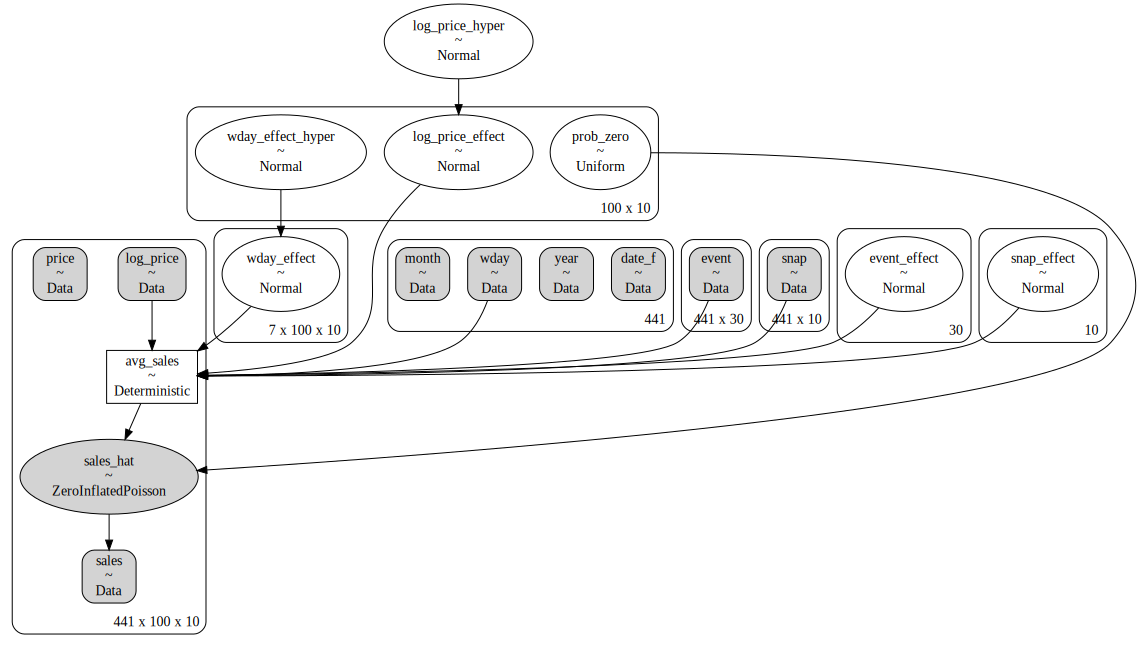

In [8]:
with pm.Model(coords=d.coords) as m:
    for k, v in d.data_vars.items():
        pm.Data(k, v, dims=v.dims)

    pm.Normal("wday_effect_hyper", mu=0, sigma=2, dims=["item_id", "store_id"])
    pm.Normal(
        "wday_effect",
        mu=m["wday_effect_hyper"][np.newaxis, :, :],
        sigma=2,
        dims=["day_of_week", "item_id", "store_id"],
    )

    pm.Normal("event_effect", mu=0, sigma=2, dims=["event_name"])
    pm.Normal("snap_effect", mu=0, sigma=2, dims=["store_id"])

    pm.Normal("log_price_hyper", mu=-1, sigma=1)
    pm.Normal(
        "log_price_effect",
        mu=m["log_price_hyper"][np.newaxis, np.newaxis],
        sigma=1,
        dims=["item_id", "store_id"],
    )
    # pm.Normal("log_price_global_effect", mu=-1, sigma=1)

    pm.Deterministic(
        "avg_sales",
        tt.exp(
            m["wday_effect"][m["wday"] - 1]
            + (m["log_price"] * m["log_price_effect"][np.newaxis, :, :])
            # + (m['log_price'] * m['log_price_global_effect'])
            + (m["event"] @ m["event_effect"])[:, np.newaxis, np.newaxis]
            + (
                m["snap"][:, np.newaxis, :]
                * m["snap_effect"][np.newaxis, np.newaxis, :]
            )
            # + m["ar_process"]
        ),
        dims=["date", "item_id", "store_id"],
    )

    pm.Uniform("prob_zero", 0, 1, dims=["item_id", "store_id"])

    pm.ZeroInflatedPoisson(
        "sales_hat",
        psi=m["prob_zero"],
        theta=m["avg_sales"],
        dims=["date", "item_id", "store_id"],
        observed=m["sales"],
    )

try:
    gv = pm.model_to_graphviz(m)
    display(gv)
except Exception as e:
    print(f"Error displaying model:\n{e!r}")

### Fit (or load trace)

In [9]:
path_model = __data__ / "model" / "v1"
path_model.mkdir(exist_ok=True, parents=True)

In [10]:
with m:
    z = pm.fit()

Finished [100%]: Average Loss = 6.5789e+05


In [25]:
z

In [28]:
with m:
    advi_post = z.sample()

In [30]:
with m:
    advi_trace = az.from_pymc3(advi_post)

0, dim: date, 441 =? 441
1, dim: item_id, 100 =? 100
2, dim: store_id, 10 =? 10


In [31]:
advi_trace

Inference data with groups:
	> posterior
	> log_likelihood
	> observed_data
	> constant_data

In [32]:
with m:
    advi_ppc_raw = pm.fast_sample_posterior_predictive(advi_trace)
    ifd3 = az.from_pymc3(posterior_predictive=advi_ppc_raw)
ppc = ifd3.posterior_predictive

In [12]:
if (path_model / "trace.nc").exists():
    trace = az.InferenceData.from_netcdf(path_model / "trace.nc")
else:
    with m:
        trace = pm.sample(
            draws=500,
            tune=300,
            chains=4,
            target_accept=0.9,
            return_inferencedata=True,
            # init="adapt_diag",
        )
    trace.to_netcdf(path_model / "trace.nc")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prob_zero, log_price_effect, log_price_hyper, snap_effect, event_effect, wday_effect, wday_effect_hyper]


Sampling 4 chains for 300 tune and 7 draw iterations (1_200 + 28 draws total) took 42641 seconds.


0, dim: date, 441 =? 441
1, dim: item_id, 100 =? 100
2, dim: store_id, 10 =? 10


The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.


### Check params

In [13]:
post_mean = trace.posterior.mean(dim=['chain', 'draw'])
post_mean

<xarray.Dataset>
Dimensions:            (date: 441, day_of_week: 7, event_name: 30, item_id: 100, store_id: 10)
Coordinates:
  * item_id            (item_id) object 'FOODS_1_001' ... 'FOODS_1_102'
  * store_id           (store_id) object 'CA_1' 'CA_2' 'CA_3' ... 'WI_2' 'WI_3'
  * day_of_week        (day_of_week) int64 0 1 2 3 4 5 6
  * event_name         (event_name) object 'SuperBowl' ... 'Easter'
  * date               (date) datetime64[ns] 2015-03-09 ... 2016-05-22
Data variables:
    wday_effect_hyper  (item_id, store_id) float64 -0.2248 0.4431 ... 0.3195
    wday_effect        (day_of_week, item_id, store_id) float64 -0.07791 ... ...
    event_effect       (event_name) float64 -0.1756 0.2181 ... 0.0527 0.1297
    snap_effect        (store_id) float64 0.02679 0.02872 ... 0.1393 0.1193
    log_price_hyper    float64 0.1657
    log_price_effect   (item_id, store_id) float64 0.1871 0.2094 ... -0.1822
    avg_sales          (date, item_id, store_id) float64 1.044 1.434 ... 1.202
    prob_zero          (item_id, store_id) float64 0.6322 0.5363 ... 0.8758

In [14]:
# az.plot_trace(trace, var_names=['prob_zero', 'wday_effect_hyper', 'ar_theta', 'ar_tau', ]);
az.plot_trace(trace, var_names=['prob_zero', 'wday_effect_hyper', 'wday_effect' ,'event_effect']);

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fae1dd83280> (for post_execute):


KeyboardInterrupt: 

In [15]:
post_mean['event_effect'].to_series().sort_values().iloc[[0, 1, 2, 3, -4, -3, -2, -1]]

event_name
Christmas        -6.584025
Thanksgiving     -0.446227
NewYear          -0.206015
SuperBowl        -0.175648
OrthodoxEaster    0.196444
PresidentsDay     0.199611
ValentinesDay     0.218095
LentStart         0.225333
Name: event_effect, dtype: float64

### Posterior prediction

In [16]:
with m:
    ppc_raw = pm.fast_sample_posterior_predictive(trace)
    ifd2 = az.from_pymc3(posterior_predictive=ppc_raw)
ppc = ifd2.posterior_predictive

### Low-level plots

In [33]:
_raw = ppc["sales_hat"]
q = xr.Dataset(
    {
        "actual": d["sales"],
        # "raw": _raw,
        "mean": _raw.mean(dim=["chain", "draw"]),
        "median": _raw.median(dim=["chain", "draw"]),
        "nonzero_avg_sales": trace.posterior['avg_sales'].mean(dim=['chain', 'draw'])
    }
)
for iw in [50, 90, 99]:
    h = az.hdi(_raw, hdi_prob=iw/100)["sales_hat"].to_dataset(dim="hdi")
    h = h.rename({"lower": f"lower_{iw}", "higher": f"higher_{iw}"})
    q = q.merge(h)

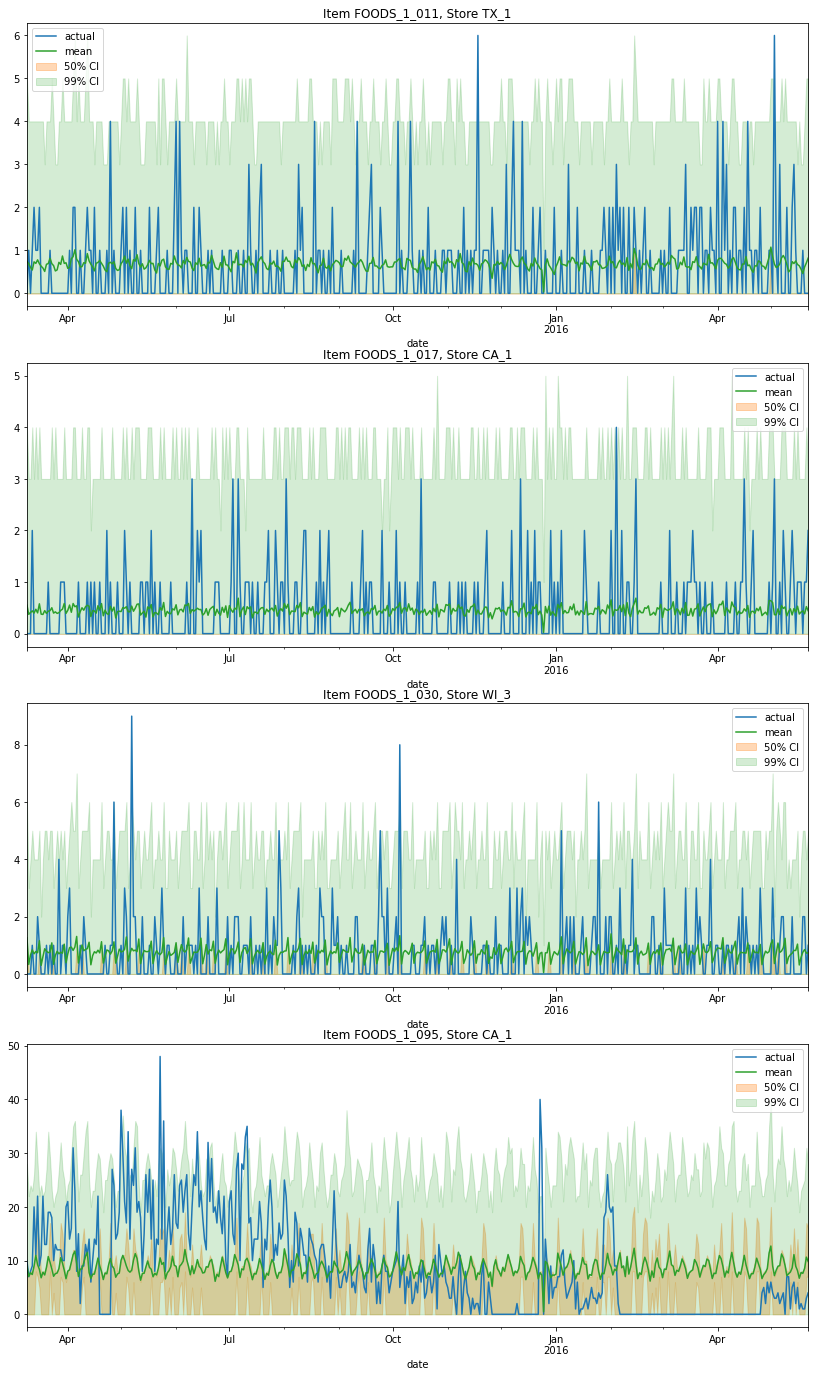

In [34]:
n_stores = min(1, len(q['store_id']))
n_items = min(4, len(q['item_id']))

rng = np.random.RandomState(10)

fig, axs = plt.subplots(n_items, n_stores, squeeze=False, figsize=(14, 6 * n_items))
for i_item in range(n_items):
    for i_store in range(n_stores):
        _item = q['item_id'].values[rng.randint(len(q['item_id']))]
        _store = q['store_id'].values[rng.randint(len(q['store_id']))]  # i_store
        
        ax = axs[i_item, i_store]
        ax.set_title(f"Item {_item}, Store {_store}")

        _q = q.isel({"store_id": i_store, "item_id": i_item})
        _df = _q.to_dataframe()[list(_q.data_vars)]
        
        _df['actual'].plot(ax=ax, color='C0')
        # _df['median'].plot(ax=ax, color='C1')
        ax.fill_between(_df.index, _df['lower_50'], _df['higher_50'], alpha=0.3, color='C1', label='50% CI')
        ax.fill_between(_df.index, _df['lower_99'], _df['higher_99'], alpha=0.2, color='C2', label='99% CI')
        _df['mean'].plot(ax=ax, color='C2')
        # _df['nonzero_avg_sales'].plot(ax=ax, color='C3', alpha=0.4)
        ax.legend()
fig;

### Aggregate plot

In [35]:
_raw1 = ppc["sales_hat"].sum(dim=["item_id", "store_id"])
a = xr.Dataset(
    {
        "actual": d["sales"].sum(dim=["item_id", "store_id"]),
        # "raw": _raw,
        "mean": _raw1.mean(dim=["chain", "draw"]),
        "median": _raw1.median(dim=["chain", "draw"]),
        "nonzero_avg_sales": (
            trace.posterior["avg_sales"]
            .sum(dim=["item_id", "store_id"])
            .mean(dim=["chain", "draw"])
        ),
    }
)
for iw in [50, 90, 99]:
    h = az.hdi(_raw1, hdi_prob=iw / 100)["sales_hat"].to_dataset(dim="hdi")
    h = h.rename({"lower": f"lower_{iw}", "higher": f"higher_{iw}"})
    a = a.merge(h)

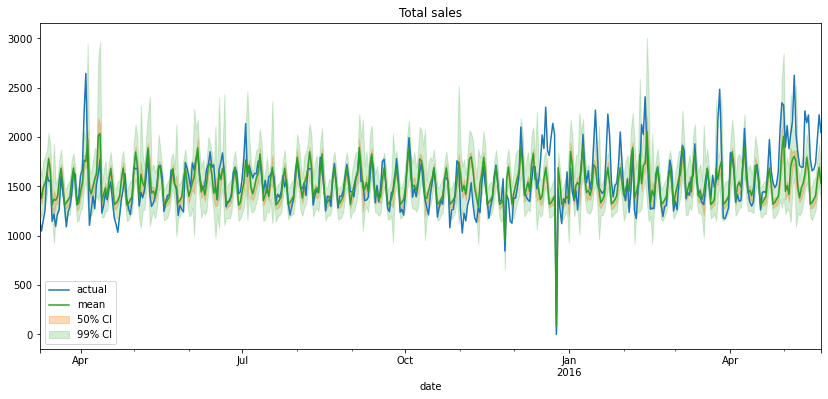

In [36]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.set_title("Total sales")

_df = a.to_dataframe()[list(a.data_vars)]

_df['actual'].plot(ax=ax, color='C0')
# _df['median'].plot(ax=ax, color='C1')
ax.fill_between(_df.index, _df['lower_50'], _df['higher_50'], alpha=0.3, color='C1', label='50% CI')
ax.fill_between(_df.index, _df['lower_99'], _df['higher_99'], alpha=0.2, color='C2', label='99% CI')
_df['mean'].plot(ax=ax, color='C2')
# _df['nonzero_avg_sales'].plot(ax=ax, color='C3', alpha=0.4)
ax.legend()
fig;

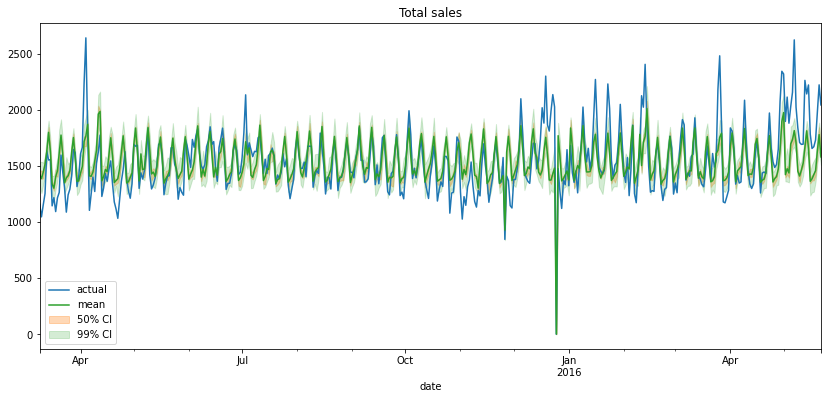

In [20]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.set_title("Total sales")

_df = a.to_dataframe()[list(a.data_vars)]

_df['actual'].plot(ax=ax, color='C0')
# _df['median'].plot(ax=ax, color='C1')
ax.fill_between(_df.index, _df['lower_50'], _df['higher_50'], alpha=0.3, color='C1', label='50% CI')
ax.fill_between(_df.index, _df['lower_99'], _df['higher_99'], alpha=0.2, color='C2', label='99% CI')
_df['mean'].plot(ax=ax, color='C2')
# _df['nonzero_avg_sales'].plot(ax=ax, color='C3', alpha=0.4)
ax.legend()
fig;